In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlsxwriter

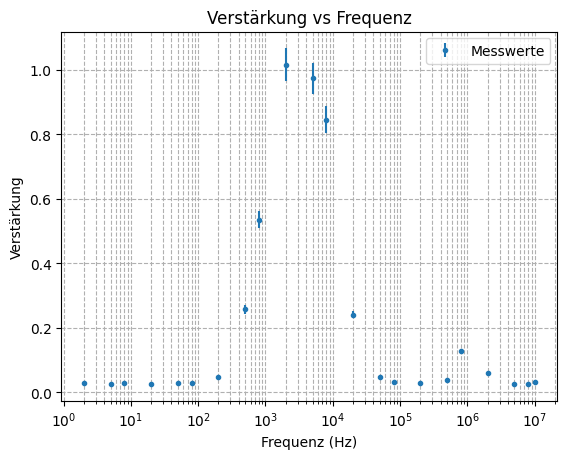

In [ ]:
data = np.loadtxt('../data/eff_Bandbreite.txt', skiprows=1)
frequenz = data[:,0]
U_in = data[:,1]
U_out = data[:,2]
U_err = 0.05 * U_out

G = U_out / U_in
G_err = G * np.sqrt((U_err / U_out)**2)

plt.errorbar(frequenz, G, yerr=G_err, fmt='.', label='Messwerte')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Verstärkung')
plt.title('Verstärkung vs Frequenz')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.savefig('../plots/eff_Bandbreite.png')
plt.show()